# Air India (Domestic) Data Analysis Project

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import shap
from xgboost import plot_importance
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import cross_val_score

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data preprocessing

In [2]:
data = pd.read_csv('./data/AirIndia (Domestic).csv')

data.columns = data.columns.str.strip().str.replace(r'\n|\(TH\)|#|\(|\)', '', regex=True).str.replace(' ', '_')

# Combining 'Month' and 'FY' into a single column
data['Month_Year'] = data['Month'] + ' ' + data['FY'].str[-2:]
data['Month_Year'] = pd.to_datetime(data['Month_Year'], format='%b %y', errors='coerce')


data['Month_Year'] = data.apply(
    lambda row: pd.to_datetime(row['Month'] + ' ' + str(int(row['FY'][-2:]) + 1), format='%b %y', errors='coerce') if pd.isna(row['Month_Year']) else row['Month_Year'], axis=1)
data['Month_Year'] = data['Month_Year'].fillna(method='bfill')

data = data.drop(columns=['Month', 'FY'])
data.set_index('Month_Year', inplace=True)

/var/folders/_d/ms_vv74d6fzcnc8gjr3s02_c0000gn/T/ipykernel_11023/443189063.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['Month_Year'] = data['Month_Year'].fillna(method='bfill')


### Correlation Matrix

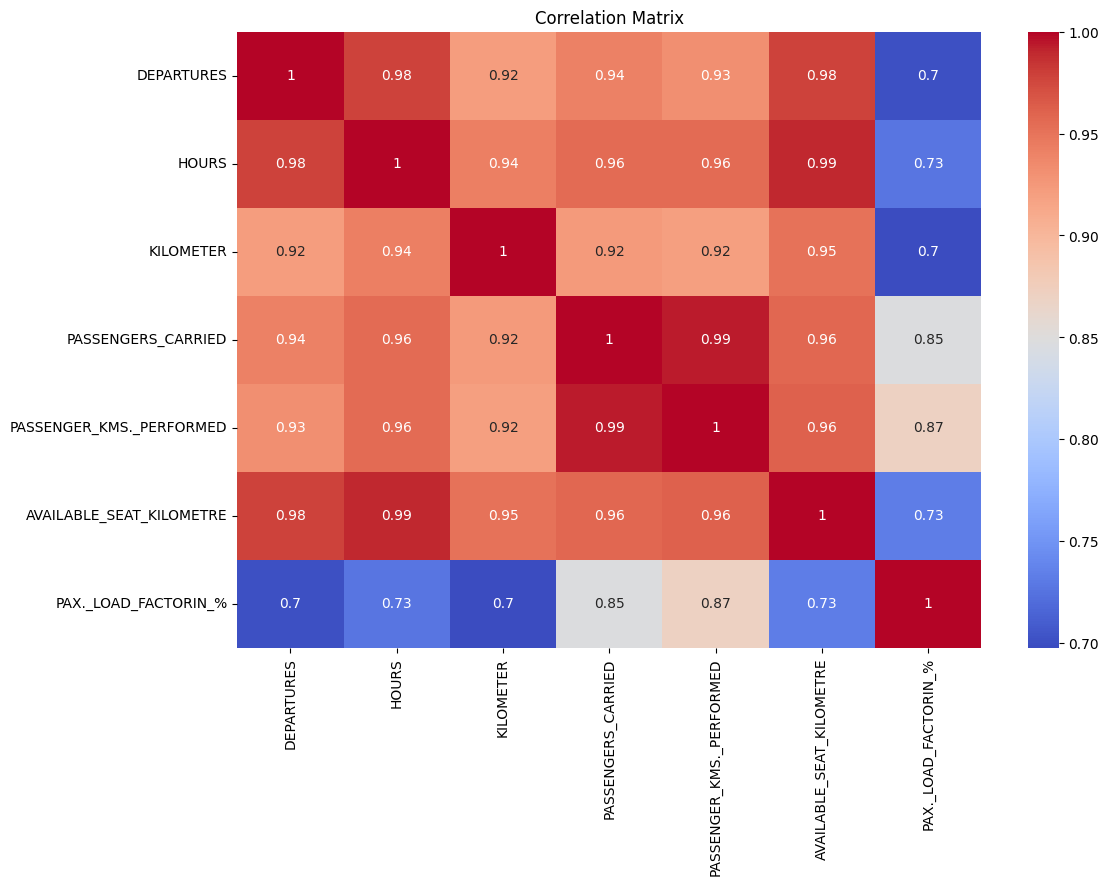

In [18]:
plt.figure(figsize=(12, 8))
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

### Time Series Plot

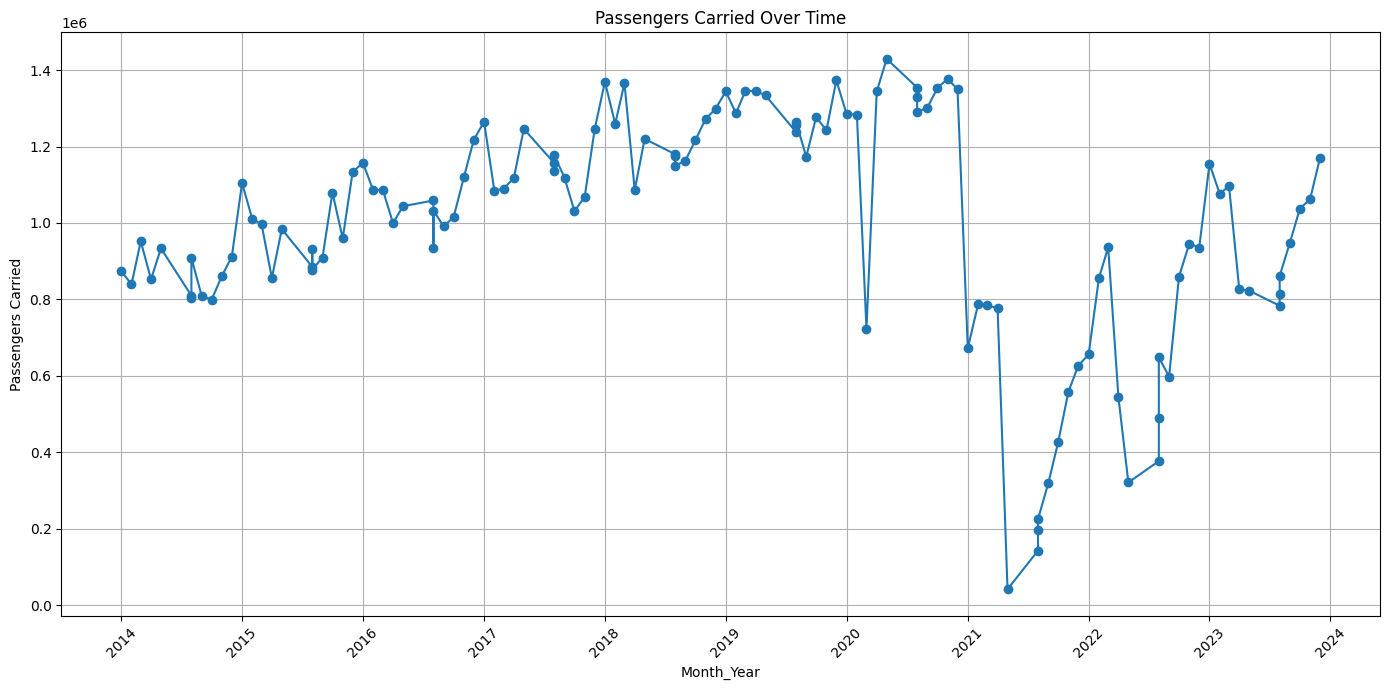

In [25]:
data_reset = data.reset_index()
data_reset = data_reset.sort_values(by='Month_Year')

plt.figure(figsize=(14, 7))
plt.plot(data_reset['Month_Year'], data_reset['PASSENGERS_CARRIED'], marker='o', linestyle='-')
plt.title('Passengers Carried Over Time')
plt.xlabel('Month_Year')
plt.ylabel('Passengers Carried')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Distribution of Passengers Carried

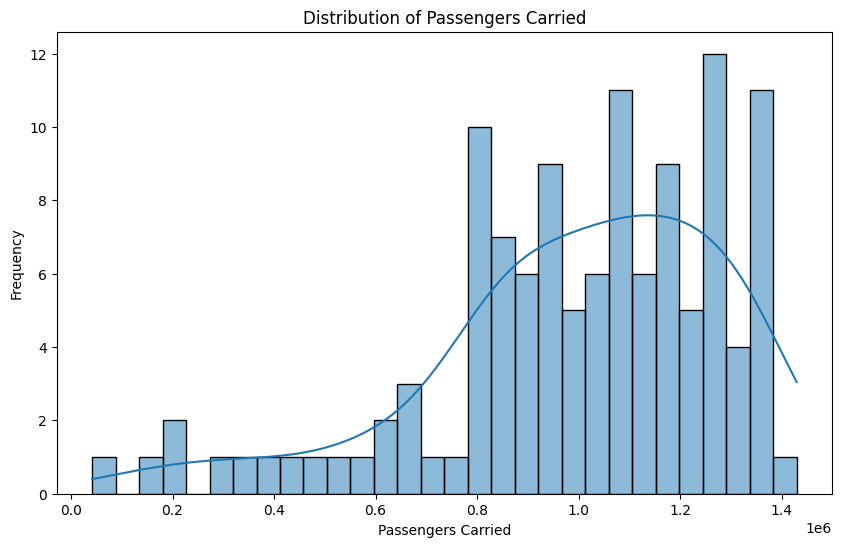

In [3]:
plt.figure(figsize=(10, 6))
sns.histplot(data['PASSENGERS_CARRIED'], bins=30, kde=True)
plt.title('Distribution of Passengers Carried')
plt.xlabel('Passengers Carried')
plt.ylabel('Frequency')
plt.show()

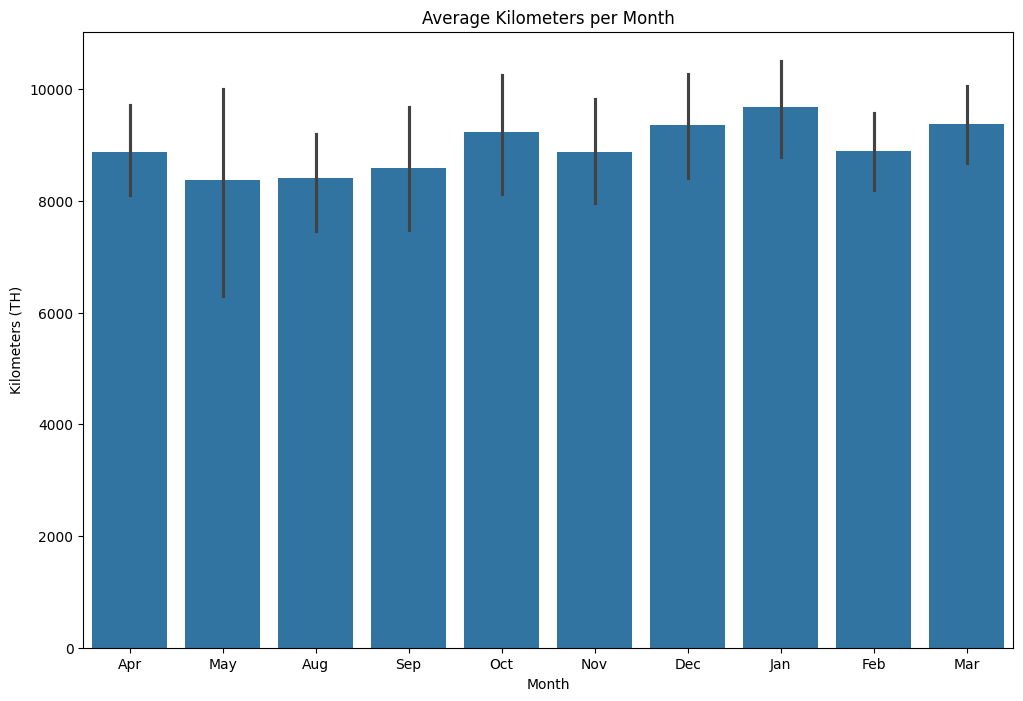

In [12]:
data_reset = data.reset_index()
data_reset['Month'] = data_reset['Month_Year'].dt.strftime('%b')

plt.figure(figsize=(12, 8))
sns.barplot(data=data_reset, x='Month', y='KILOMETER')
plt.title('Average Kilometers per Month')
plt.xlabel('Month')
plt.ylabel('Kilometers (TH)')
plt.show()

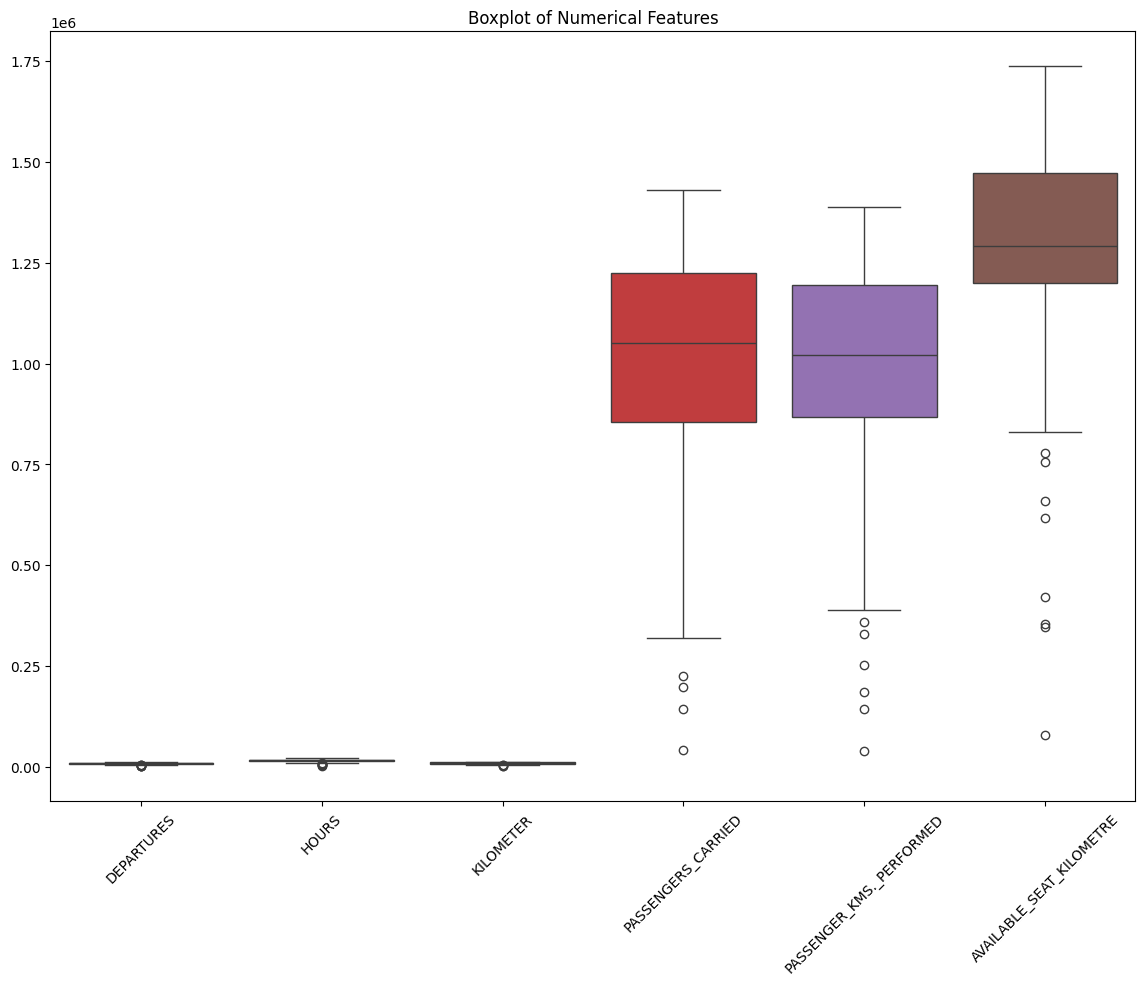

In [9]:
# Box Plot for different numerical features
plt.figure(figsize=(14, 10))
sns.boxplot(data=data.drop(['PAX._LOAD_FACTORIN_%'], axis=1))
plt.title('Boxplot of Numerical Features')
plt.xticks(rotation=45)
plt.show()

/var/folders/_d/ms_vv74d6fzcnc8gjr3s02_c0000gn/T/ipykernel_11023/1180861413.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=data_reset, x='Year', y='PASSENGERS_CARRIED', ci=None)


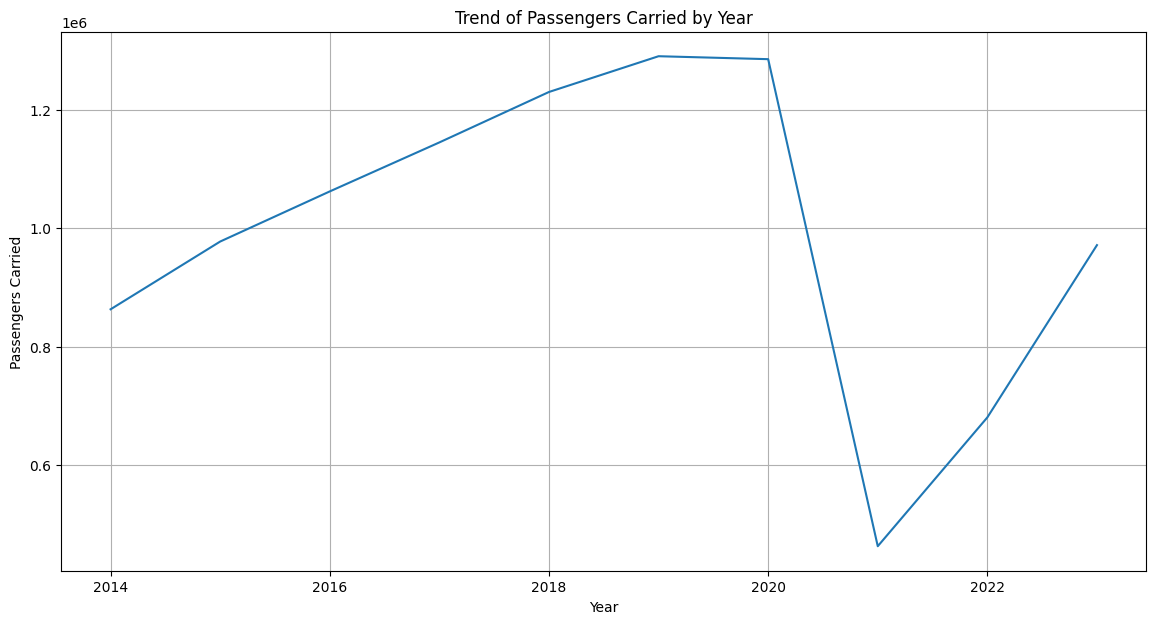

In [15]:
data_reset['Year'] = data_reset['Month_Year'].dt.year
plt.figure(figsize=(14, 7))
sns.lineplot(data=data_reset, x='Year', y='PASSENGERS_CARRIED', ci=None)
plt.title('Trend of Passengers Carried by Year')
plt.xlabel('Year')
plt.ylabel('Passengers Carried')
plt.grid(True)
plt.show()

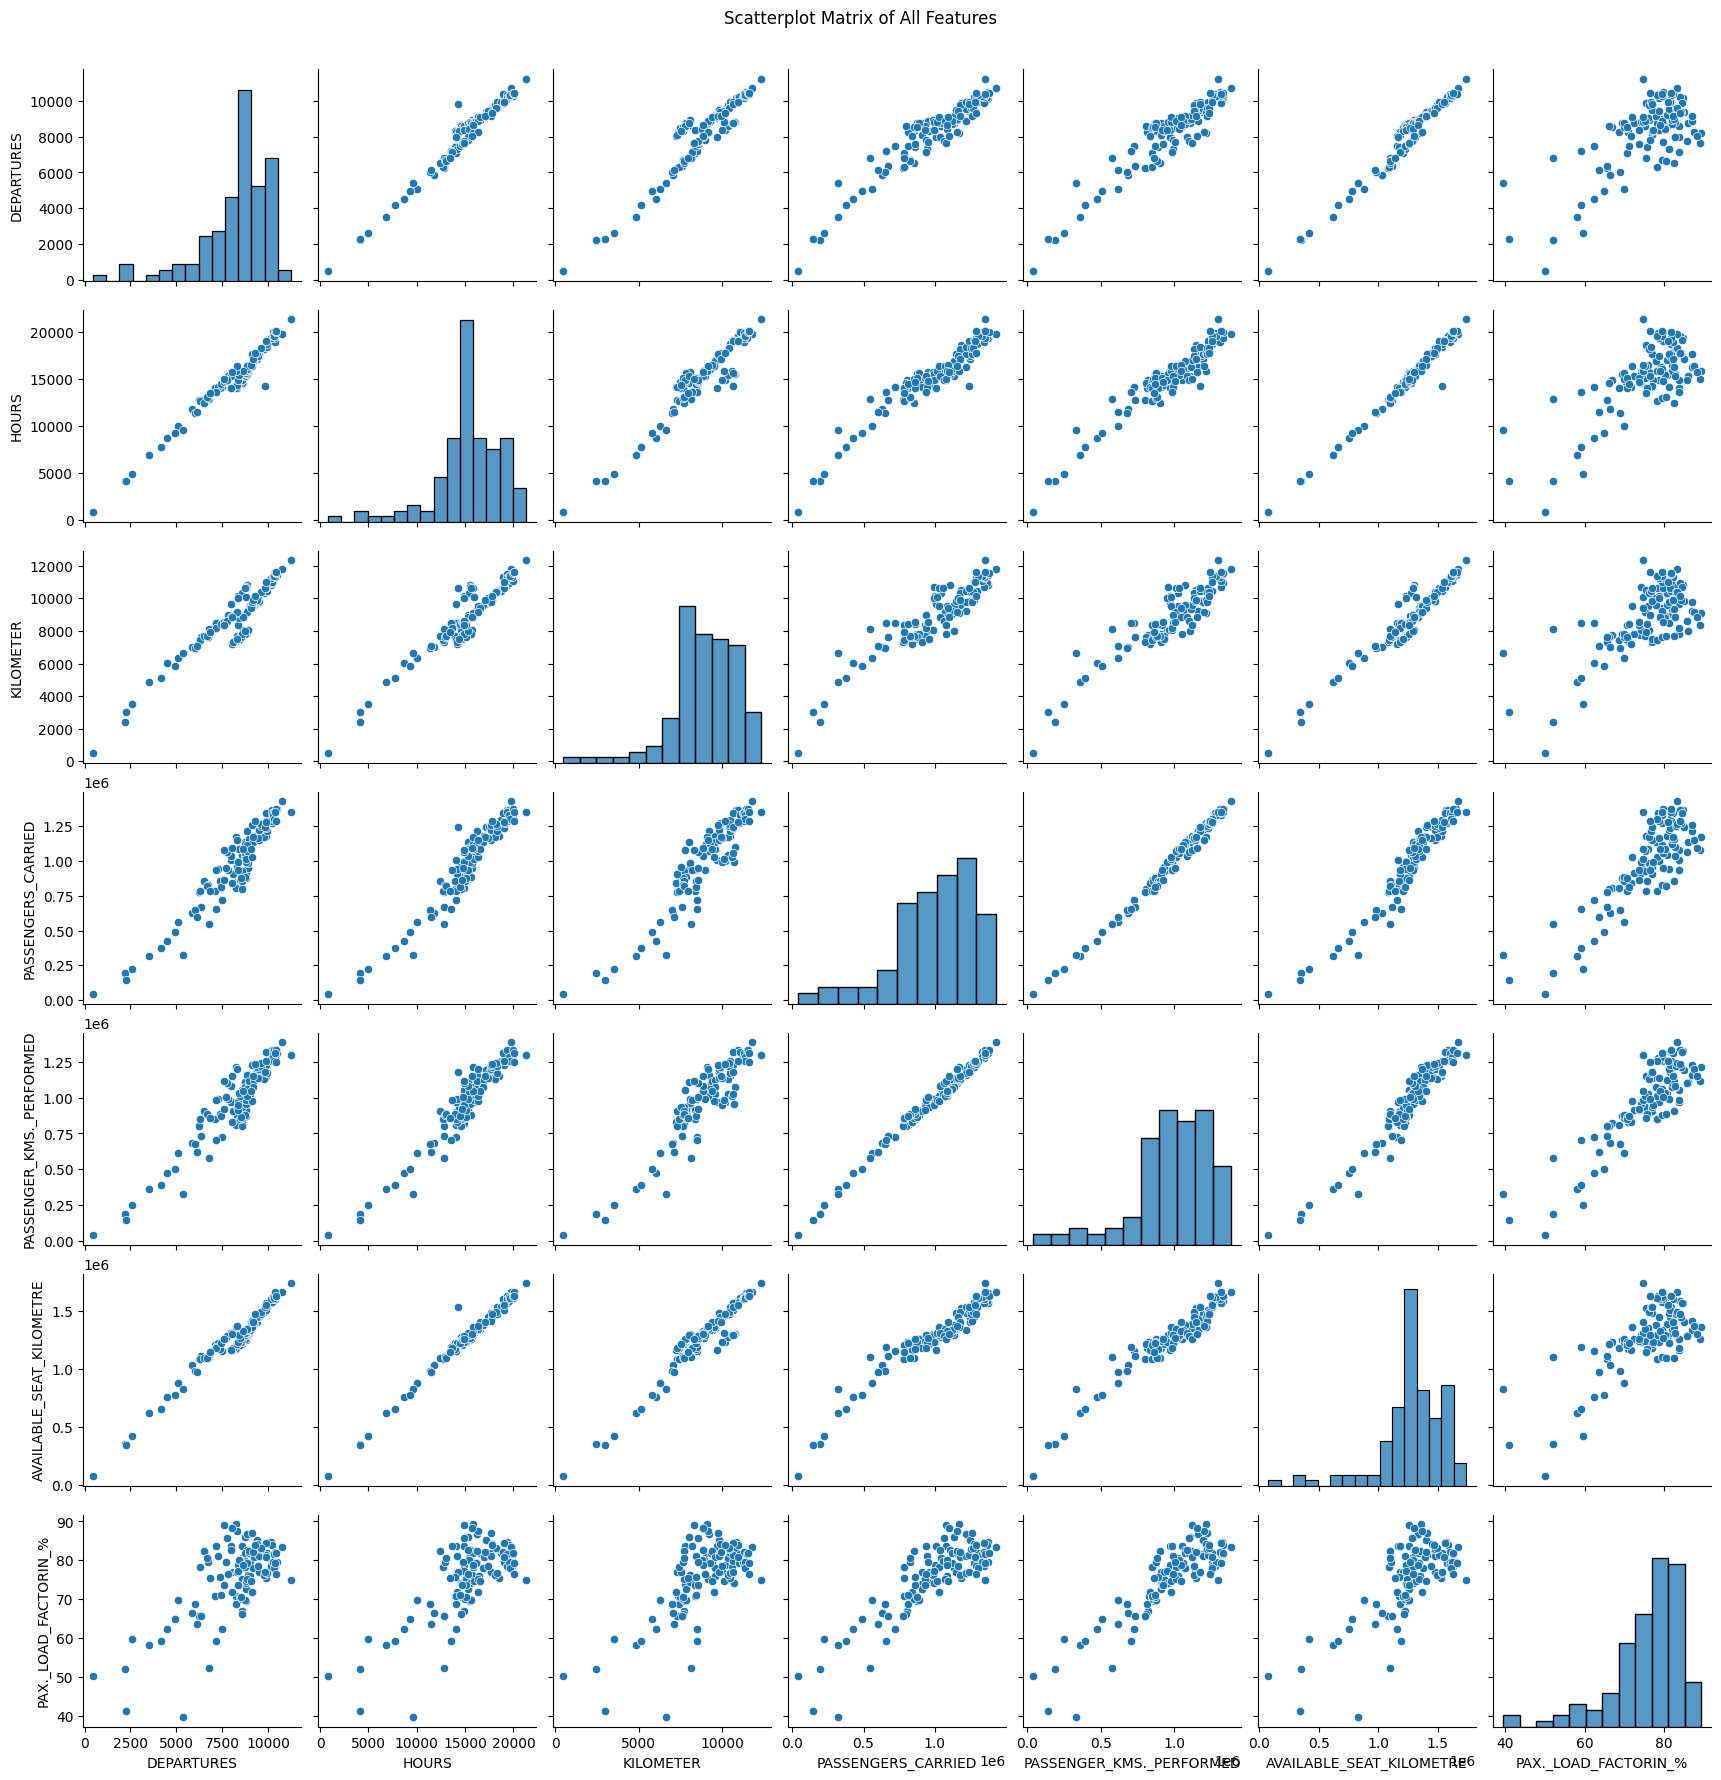

In [11]:
# Scatterplot matrix
sns.pairplot(data)
plt.suptitle('Scatterplot Matrix of All Features', y=1.02)
plt.show()

In [19]:
# Feature Engineering
X = data[['DEPARTURES', 'HOURS', 'KILOMETER', 'PASSENGER_KMS._PERFORMED', 'AVAILABLE_SEAT_KILOMETRE', 'PAX._LOAD_FACTORIN_%']]
y = data['PASSENGERS_CARRIED']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)

# Hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2)
grid_search.fit(X_train_scaled, y_train)

# Best parameters
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

# Train the best model
best_model = grid_search.best_estimator_
best_model.fit(X_train_scaled, y_train)


Fitting 3 folds for each of 729 candidates, totalling 2187 fits
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.9; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.9; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.9; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=1.0; tot

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

Mean Squared Error: 1114328725.286377
Root Mean Squared Error: 33381.562654950365
Mean Absolute Error: 26380.9453125
R-squared: 0.9869591420590705
Cross-validated RMSE: 44676.28214073257


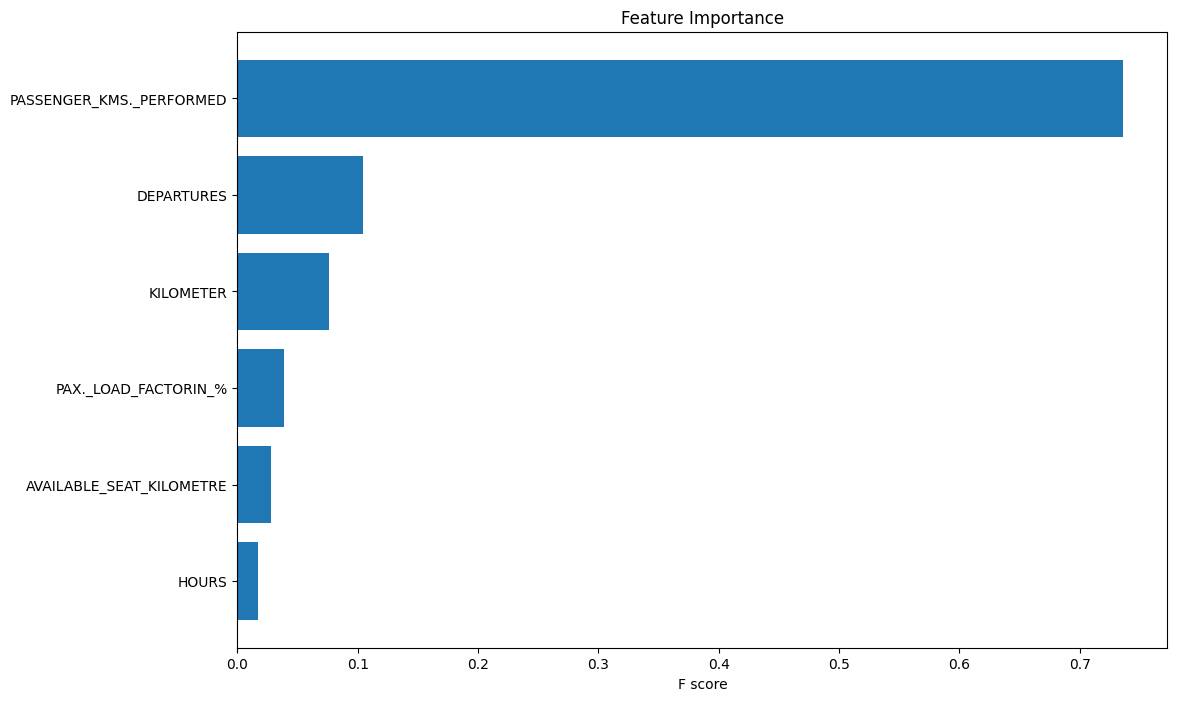

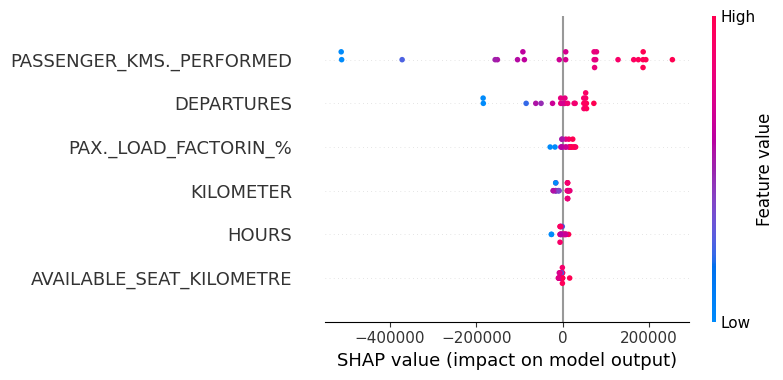

In [29]:
y_pred = best_model.predict(X_test_scaled)

# Evaluation metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"R-squared: {r2}")

# Cross-validation
cv_scores = cross_val_score(best_model, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')
cv_rmse = np.sqrt(-cv_scores)
print(f"Cross-validated RMSE: {cv_rmse.mean()}")

feature_names = ['DEPARTURES', 'HOURS', 'KILOMETER', 'PASSENGER_KMS._PERFORMED', 'AVAILABLE_SEAT_KILOMETRE', 'PAX._LOAD_FACTORIN_%']

importances = best_model.feature_importances_
indices = np.argsort(importances)

# Plot feature importances
plt.figure(figsize=(12, 8))
plt.title('Feature Importance')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('F score')
plt.show()

# SHAP summary plot with feature names
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test_scaled, feature_names=feature_names)
plt.show()
